<a href="https://colab.research.google.com/github/iurrutia/CQ_with_Word_Macro/blob/master/sigmajs_tobrowser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install ForceAtlas2
!pip install numpy 
!pip install cython
import networkx as nx
from IPython.core.display import display, HTML
from string import Template


We read in our graph and give it a pos attribute (dictionary of positions):

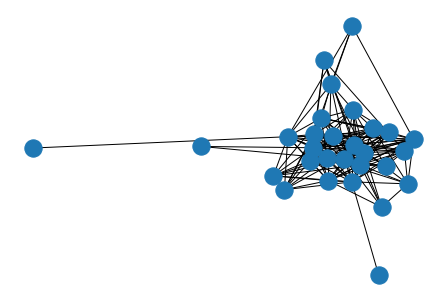

In [5]:
G = nx.read_gexf("g_w_vfa.gexf")
nx.draw(G)
# The file read in must contain position arguments.

In [25]:
# Examine node labels:
G.nodes('label')

NodeDataView({'amy': 'amy', 'abby': 'abby', 'antonia': 'antonia', 'barry': 'barry', 'caroline.hatfield': 'caroline.hatfield', 'catherine': 'catherine', 'charlie.odom': 'charlie.odom', 'carson': 'carson', 'cris': 'cris', 'elizabeth': 'elizabeth', 'helen': 'helen', 'jed': 'jed', 'josh': 'josh', 'julia.kortberg': 'julia.kortberg', 'kate': 'kate', 'katie.grimm': 'katie.grimm', 'keenan': 'keenan', 'rick': 'rick', 'sara': 'sara', 'sarah.craft': 'sarah.craft', 'vanessa': 'vanessa', 'winson': 'winson', 'andrew.albert': 'andrew.albert', 'barrie': 'barrie', 'betsye': 'betsye', 'carrie': 'carrie', 'joel': 'joel', 'marley': 'marley', 'chelsea': 'chelsea'}, data='label')

In [22]:
# Node that nodes have no pos argument:
G.nodes()['amy']

{'centrality': 0.28035098294124083,
 'cluster': 7,
 'critical': 1,
 'label': 'amy',
 'team': 'C-Suite'}

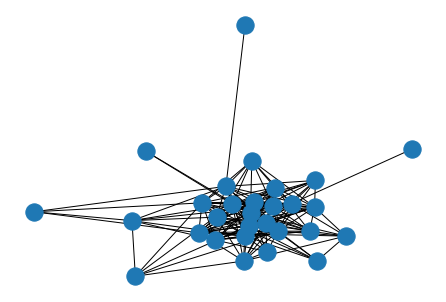

In [39]:
# pos = nx.drawing.nx_pylab.draw_spectral(G)
# pos = nx.drawing.nx_pylab.draw_shell(G)
# pos = nx.drawing.nx_pylab.draw_kamada_kawai(G)
# pos = nx.random_layout(G)
# pos = nx.spring_layout(G)
# Equivalent to:
pos = nx.fruchterman_reingold_layout(G)
# pos = nx.circular_layout(G)

nx.draw(G, pos)

Alternatively, pos can be generated using the ForceAtlas2 algorithm, shown here:

100%|██████████| 2000/2000 [00:00<00:00, 13429.27it/s]


BarnesHut Approximation  took  0.04  seconds
Repulsion forces  took  0.06  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


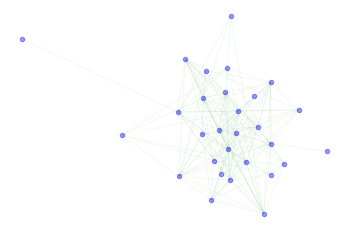

In [51]:
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=20, with_labels=False, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

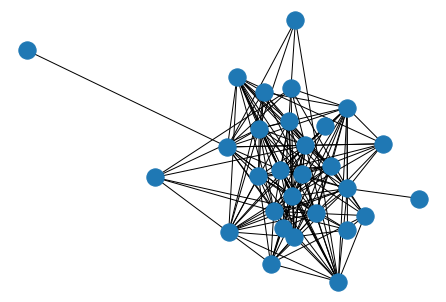

In [52]:
nx.draw(G, positions)

In [0]:
pos = positions # if using ForceAtlas2

for i,label in enumerate(G.nodes().keys()):
  G.nodes()[label]['viz'] = {
      'position': {
        'x': pos[label][0],
        'y': pos[label][1],
      },
      'size': 1,
  }

In [0]:
nx.write_gexf(G, 'G_sig.gexf')

Although we eventually want to display the graph on a webpage, we can download sigma.js to a notebook environment, in case we want to fiddle with the layout/image locally here.

In [68]:
# download sigma.js to notebook environment
import urllib
urllib.request.urlretrieve("https://github.com/jacomyal/sigma.js/releases/download/v1.2.0/build.zip", "sigmajs-1.2.0.zip")

('sigmajs-1.2.0.zip', <http.client.HTTPMessage at 0x7f3529af02e8>)

In [0]:
from zipfile import ZipFile
with ZipFile('sigmajs-1.2.0.zip', 'r') as zf:
    zf.extractall('sigmajs-1.2.0/')

Start a http server inside the notebook
This server makes the files in the notebook's environment available to the browser--in particular, we need this to be able to use the sigmajs library we downloaded above.

In [0]:
# start up an HTTP server inside the notebook to serve the sigmajs scripts

import portpicker
import threading
import socket
import IPython

from six.moves import socketserver
from six.moves import SimpleHTTPServer

class V6Server(socketserver.TCPServer):
  address_family = socket.AF_INET6

Handler = SimpleHTTPServer.SimpleHTTPRequestHandler

port = portpicker.pick_unused_port()

def server_entry():
    httpd = V6Server(('::', port), Handler)
    # Handle a single request then exit the thread.
    httpd.serve_forever()

thread = threading.Thread(target=server_entry)
thread.start()

# Render the graph

## Peculiarities running inside the notebook

Here, we need to access the sigmajs files, and our gexf file through 'https://localhost:1234/...', where 1234 is the port where the server we started above is running. We use string.format to substitute the correct port number (e.g. "https://localhost:{port}").

One other thing--every place that the tutorial html contains '{' or '}' characters, we need to replace those with '{{' or '}}', or else string.format will think we are opening up a substitution, like '{port}'.

In [73]:
html = """
<script src="https://localhost:{port}/sigmajs-1.2.0/build/sigma.min.js"></script>
<script src="https://localhost:{port}/sigmajs-1.2.0/build/plugins/sigma.parsers.gexf.min.js"></script>

<style type="text/css">
  #container {{
    max-width: 100%;
    height: 400px;
    margin: auto;
  }}
</style>

<div id="container"></div>
<script>
  sigma.parsers.gexf('https://localhost:{port}/G_sig.gexf', {{
    container: 'container',
    settings: {{
      defaultNodeColor: '#ec5148'
    }}
  }});
</script>
""".format(port=port)

display(IPython.display.HTML(html))